In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/Users/cathy/opt/anaconda3/envs/mfe-preprogram/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def hourly_return(df):
    df = df.close/df.close.shift(1) -1
    return df

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def max_drawdown(df):
    peak = df['close'].cummax()
    print(peak)
    hourly_dd = df['close']/peak -1
    print(hourly_dd)
    mdd = hourly_dd.cummin()
    return mdd

In [5]:
def series_plot(data, title, ax=None):
    data.plot(ax=ax)
    ax.set_title(title)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [6]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-12'
connection_string = 'sqlite:///../../../Lectures/Lecture 4/data/data.db'

In [7]:
# Parameters
from_date = "2021-12-12 00:00:00"
to_date = "2021-12-19 00:00:00"
token = "SOL"
connection_string = "sqlite:///../../../Lectures/Lecture 4/data/data.db"


In [8]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [9]:
prices['hourly_return'] = hourly_return(prices)
prices['hourly_vol_ohlc'] = vol_ohlc(prices)
prices['hourly_max_drawdown'] = max_drawdown(prices)

ts
2021-12-12 00:00:00    172.16
2021-12-12 01:00:00    172.16
2021-12-12 02:00:00    172.16
2021-12-12 03:00:00    172.16
2021-12-12 04:00:00    172.16
                        ...  
2021-12-14 20:00:00    175.47
2021-12-14 21:00:00    175.47
2021-12-14 22:00:00    175.47
2021-12-14 23:00:00    175.47
2021-12-15 00:00:00    175.47
Name: close, Length: 73, dtype: float64
ts
2021-12-12 00:00:00    0.000000
2021-12-12 01:00:00   -0.007842
2021-12-12 02:00:00   -0.015451
2021-12-12 03:00:00   -0.018587
2021-12-12 04:00:00   -0.013011
                         ...   
2021-12-14 20:00:00   -0.121787
2021-12-14 21:00:00   -0.099048
2021-12-14 22:00:00   -0.084972
2021-12-14 23:00:00   -0.094147
2021-12-15 00:00:00   -0.091868
Name: close, Length: 73, dtype: float64


In [10]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

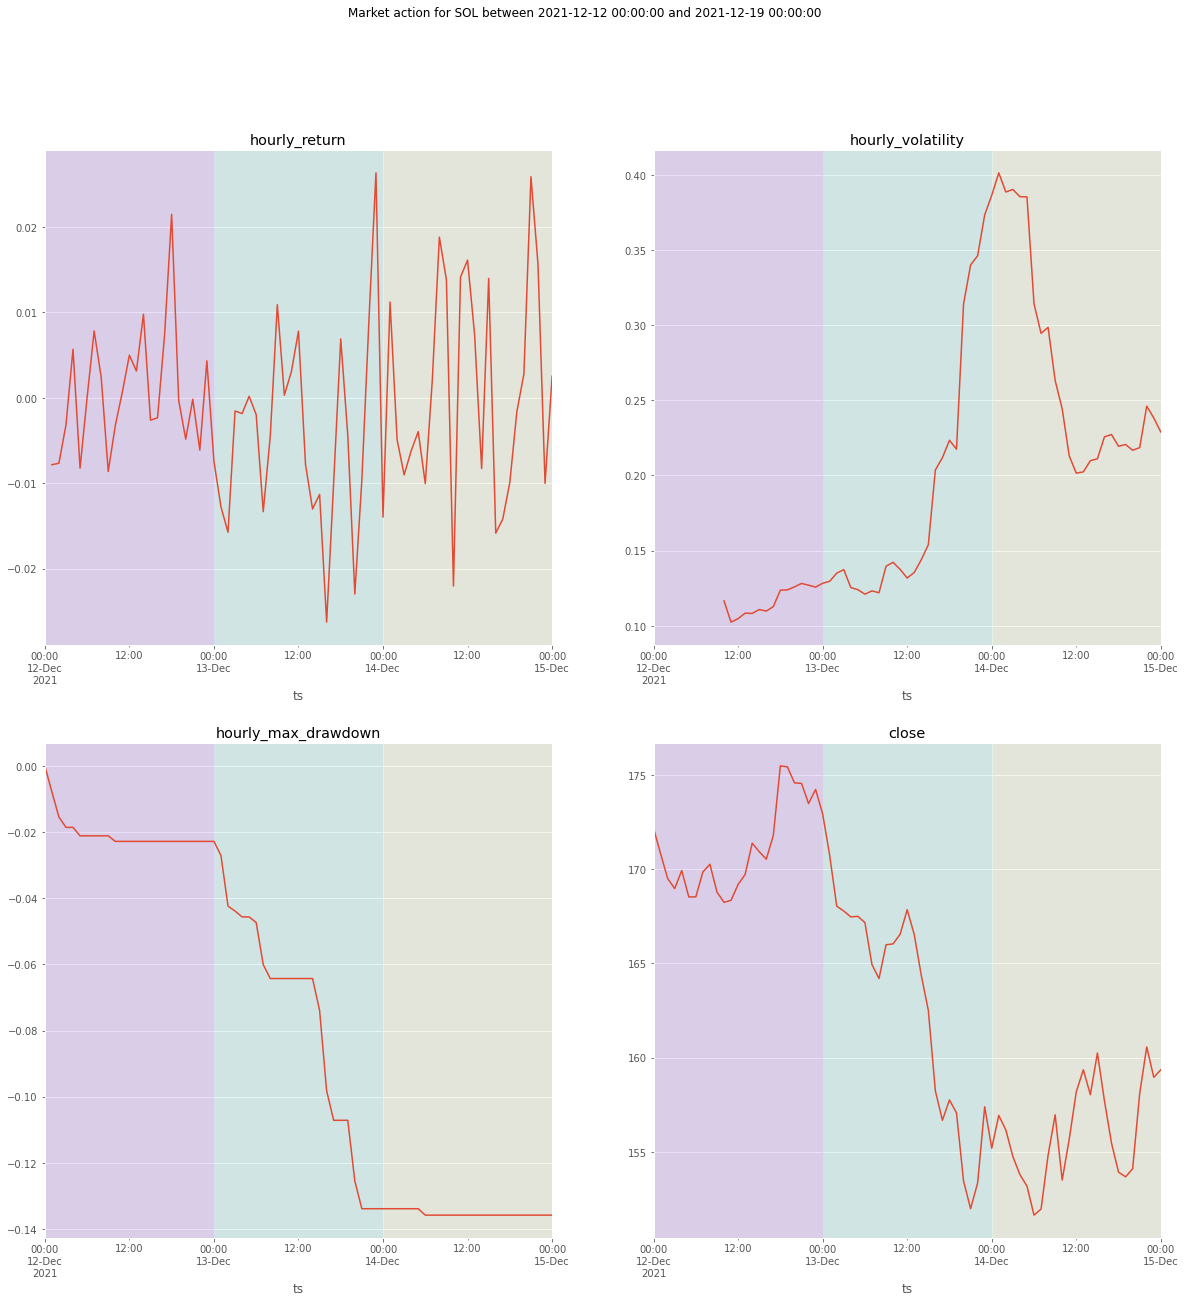

In [11]:
series_plot(prices['hourly_return'], 'hourly_return', ax=ax[0, 0])
series_plot(prices['hourly_vol_ohlc'], 'hourly_volatility', ax=ax[0, 1])
series_plot(prices['hourly_max_drawdown'], 'hourly_max_drawdown', ax=ax[1, 0])
series_plot(prices['close'], 'close', ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

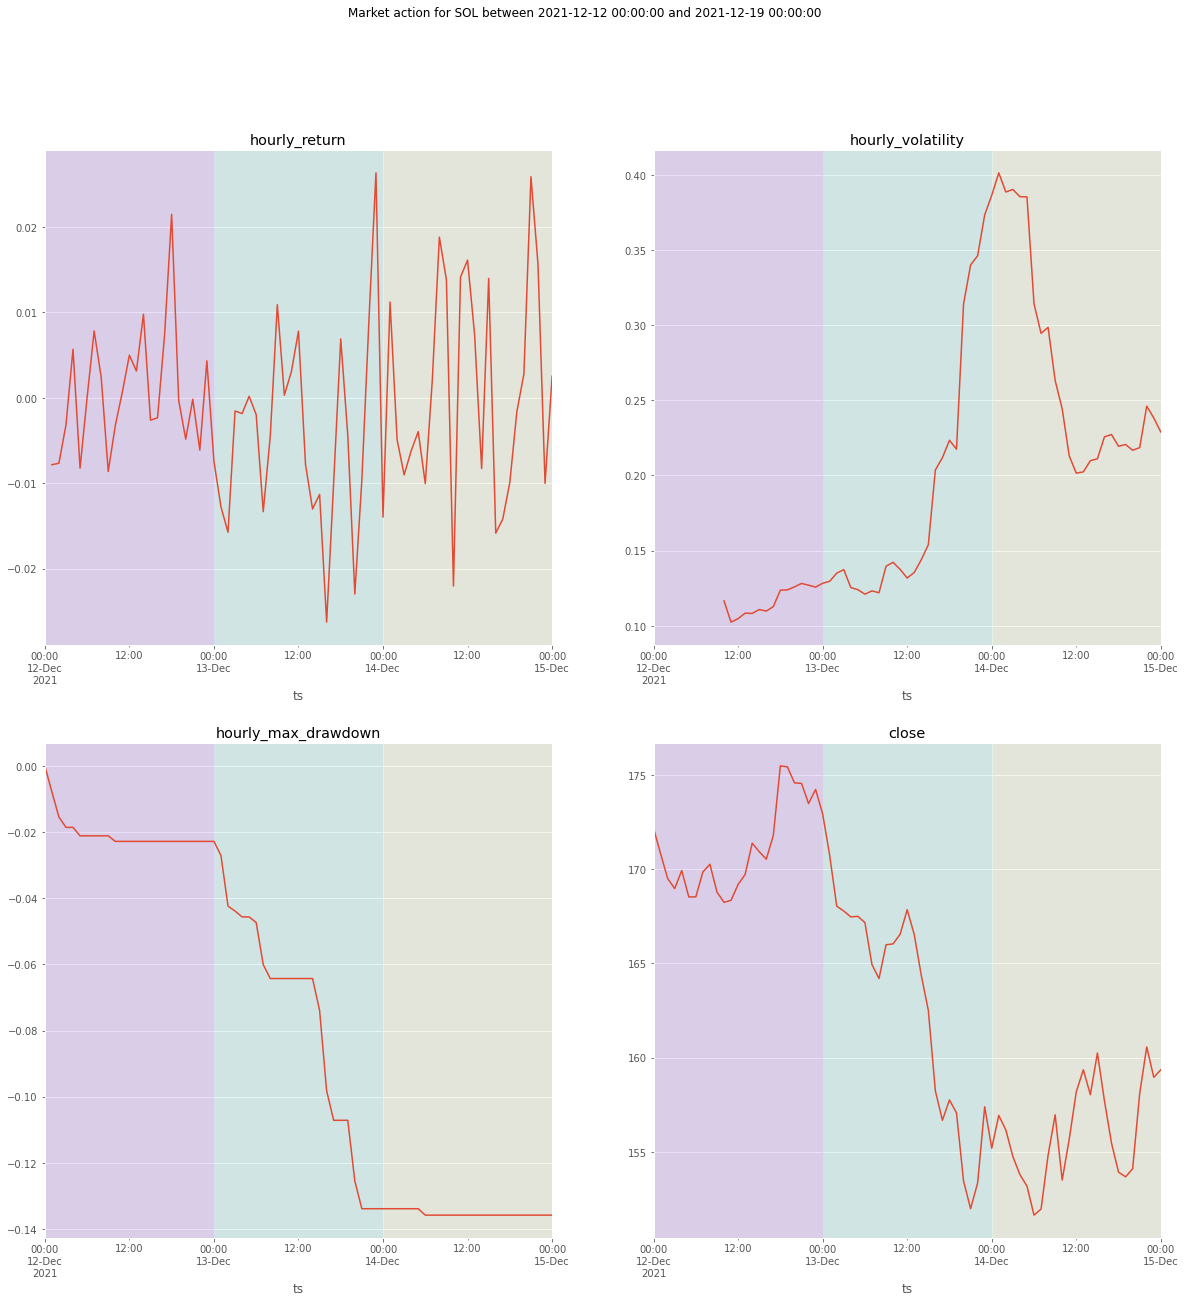

In [12]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)